# Modelo de redes neurais recorrentes para previsão do preço das ações

Os dados diários para cada ano podem ser obtidos aqui: http://bvmf.bmfbovespa.com.br/InstDados/SerHist/COTAHIST_A2020.ZIP

**Spoiler:** Não é possível prever o preço das ações a partir de preços passados.

In [1]:
import pandas as pd
import numpy as np
import requests
import zipfile
import io

## Funções

In [2]:
def download_zip_data(url, save_dir, verbose=False):
    """
    Download a zip file at `url` web address, unzip it and save it to `save_dir`.
    """
    # Initialize session:
    session = requests.session()
    session.mount('http://', requests.adapters.HTTPAdapter(max_retries=3))
    
    # Download data:
    if verbose:
        print('Downloading ' + url)
    response = session.get(url, timeout=900)
    
    # Unzip data if download is successful:
    if response.status_code == 200:
        if verbose:
            print('Unzipping data to ' + save_dir)
        z = zipfile.ZipFile(io.BytesIO(response.content))
        z.extractall(save_dir)
    else:
        if verbose:
            print('Failed with status code', response.status_codeatus_code)
    
    return response.status_code

In [3]:
def get_bovespa_data(year, save_dir='../dados/brutos/', verbose=False):
    """
    Download stock historical series from BVMF (Bovespa) for `year` (int or str)
    and save the unzipped raw file to `save_dir` (str).
    """
    url_template = 'http://bvmf.bmfbovespa.com.br/InstDados/SerHist/COTAHIST_A%(year)s.ZIP'
    url = url_template % {'year': year}
    download_zip_data(url, save_dir, verbose)

In [4]:
def load_raw_bovespa_data(filename, verbose=False, print_layout=False):
    """
    Load the raw TXT data (fixed width format) about BVMF (Bovespa) stocks
    from `filename` (str). The file layout is hard-coded.
    
    If `verbose` (bool) is True, print messages.
    If `print_layout` is True, print the current hard-coded layout.
    
    Return: df (DataFrame)
    """
    
    # HARD-CODED STUFF:
    
    # Posição inicial de cada campo, concatenado com a "posição final + 1" do último campo:
    pos_divisao  = np.array([1,3,11,13,25,28,40,50,53,57,70,83,96,109,122,135,148,153,171,189,202,203,211,218,231,243,246])
    # Nome das colunas:
    col_names = ['tipo_registro', 'data_pregao', 'cod_bdi', 'cod_negociacao_papel', 
                 'tipo_mercado', 'nome_empresa', 'especificacao_papel', 'prazo_termo',
                 'moeda', 'abertura', 'maximo', 'minimo', 'preco_medio', 'preco_ultimo', 
                 'melhor_oferta_compra', 'melhor_oferta_venda', 'num_negocios', 
                 'num_titulos', 'volume', 'preco_opcoes', 'correcao_precos', 
                 'data_venc_opcoes', 'fator_cotacao', 'preco_opcoes_us', 'cod_isin',
                 'num_distrib']
    
    # Calcula o limite de cada campo a partir da `pos_divisao`:
    pos_divisao  = pos_divisao - 1
    field_limits = list(zip(pos_divisao[:-1], pos_divisao[1:]))

    # Sanity check:
    assert len(field_limits) == len(col_names), 'Hard-coded column names and field limits do not have the same number of elements'

    if print_layout:
        print('============== Layout ==============')
        # Tabela de colunas com limites semi-aberto [i,j) (com começo em 0):
        print(pd.DataFrame({'nome': col_names, 'range': field_limits}))

    # Carrega os dados:
    if verbose:
        print('Loading BVMF data from ' + filename + '...')
    # Load data:
    df = pd.read_fwf(filename, colspecs=field_limits, skiprows=1, skipfooter=1, names=col_names)
    
    return df

In [5]:
def clean_bovespa_data(df, verbose=False):
    """
    Take a raw BVMF (Bovespa) DataFrame `df` and clean it in place by:
    - Removing unecessary columns (constant values);
    - Parsing dates;
    - Sanity checking some fields.
    
    Return: df (DataFrame)
        Cleaned DataFrame (also cleaned in place).
    """
    
    # Eliminate columns whose values are always the same known one:
    if verbose:
        print("Dropping 'tipo_registro' column...")
    assert (df['tipo_registro'].unique() == np.array([1])).all(), "Found a 'tipo_registro' entry that is not 1."
    df.drop(['tipo_registro'], axis=1, inplace=True)
    if verbose:
        print("Dropping 'moeda' column...")
    assert (df['moeda'].unique() == np.array(['R$'])).all(), 'Found a currency that is not R$.'
    df.drop(['moeda'], axis=1, inplace=True)
    
    # Parse dates:
    if verbose:
        print("Parsing 'data_pregao' column...")
    df['data_pregao']      = pd.to_datetime(df['data_pregao'], format='%Y%m%d')
    df['data_venc_opcoes'] = pd.to_datetime(df['data_venc_opcoes'], format='%Y%m%d', errors='coerce')
    # Check the range of certain fields:
    if verbose:
        print("Asserting column value ranges...")
    assert ((df['cod_bdi'] > 1) & (df['cod_bdi'] < 100)).all(), "Found a out-of-range (2-99) 'cod_bdi'."
    assert ((df['tipo_mercado'] >= 10) & (df['tipo_mercado'] <= 80)).all(), "Found a out-of-range (10-80) 'tipo_mercado'."
    
    # Parse values from centavos to reais:
    if verbose:
        print("Parsing currency values from centavos to reais...")
    value_columns = ['abertura', 'maximo', 'minimo', 'preco_medio', 'preco_ultimo', 
                     'melhor_oferta_compra', 'melhor_oferta_venda', 'volume', 'preco_opcoes']
    for col in value_columns:
        try:
            df[col] = df[col] / 100
        except:
            print("Failed to parse currency values at column '" + col + "'.")
            
    return df

In [6]:
def place_entry_after(entry_array, previous_entry, new_entry):
    """
    Given an array-like object `entry_array`, insert `new_entry`
    (object or list of objects) in `entry_array` right after 
    `previous_entry`.
    """
    
    # Safe checks:
    if np.sum(entry_array == previous_entry) < 1:
        raise Exception("`previous_entry` '{}' not found in `entry_array`.".format(previous_entry))
    if np.sum(entry_array == previous_entry) > 1:
        raise Exception("`previous_entry` '{}' is not unique in `entry_array`.".format(previous_entry))
    
    # Find position where to insert new entry:
    previous_pos = np.where(entry_array == previous_entry)[0][0]
    new_pos      = previous_pos + 1
    # Insert new entry:
    new_array     = np.insert(entry_array, new_pos, new_entry)

    return new_array

In [7]:
def join_data_from_file(df, filename, df_key, file_key):
    """
    Load data from a CSV file `filename` (str) and left
    join it to `df` (DataFrame) using `df` column 
    `df_key` (str or int) and the CSV column `file_key` 
    (str or int) as keys. The columns in the CSV file 
    are inserted right after `df_key`.
    """
    
    # Load data and set the key as index:
    data = pd.read_csv(filename)
    data = data.set_index(file_key)
    # List the remaining columns in data:
    data_cols = data.columns
    
    # Create a list of columns with the new data: 
    new_cols = place_entry_after(df.columns, df_key, data_cols)
    
    # Join data right after key column:    
    joined = df.join(data, on=df_key, how='left')[new_cols]
    
    return joined

In [8]:
def extract_especificacao_base(especificacao_papel):
    """
    Extract the first term from Series `especificacao_papel`,
    including the symbols '*' and '<'. This first term is 
    supposed to be the main kind of the stock. 
    """
    
    return series.str.slice(0, 4).str.strip()


def extract_especificacao_events(especificacao_papel):
    """
    Extract events such as 'ex-dividendos', 'ex-grupamento', 
    etc. from Series `especificacao_papel`.
    """
    
    return especificacao_papel.str.extract('[ *^](E[^ ]+|INT|REC|UNT)')[0]

In [9]:
def id_artificial_price_changes(df, events='GB'):
    """
    Return a Series that tells if an entry in Bovespa
    DataFrame `df` refers to an artificial price change
    caused by grupamento/bonificação (1), or not (0).
    """
    
    # Sort dataframe to group stocks and place each one in chronological order:
    sorted_df = df.sort_values(['cod_negociacao_papel', 'data_pregao'])
  
    # Find out when there was a change in the stock distribution number:
    change_distrib = sorted_df['num_distrib'].diff().fillna(0).astype(int)    
    # Find out if stock is the same as the one before:
    same_stock = sorted_df['cod_negociacao_papel'] == sorted_df['cod_negociacao_papel'].shift().fillna(method='bfill')
    # Check if the event is one that artificially changes prices:
    change_event = sorted_df['eventos'].str.contains('^E.*[{}]'.format(events))
    
    # Get indicator of artificial changes in stocks:
    artificial_changes = (change_distrib & same_stock & change_event).astype(int).sort_index()
    
    return artificial_changes

In [10]:
def compute_price_chance(df, price_col, frac_diff, fix_artificial_change=True, min_denom=None):
    """
    Compute the price difference for all stocks in 
    `df` between today and the day before. 
    
    Input
    -----
    
    df : DataFrame
        The Bovespa data, with prices for all stocks 
        and all dates.
        
    price_col : str
        The name of the price column to compute the
        variation for.
        
    frac_diff : bool or str
        Whether to compute the fractional difference
        of the prices (True) or to compute the 
        absolute difference (False). If 'log', compute
        the natural log of the price fraction.
    
    fix_artificial_change : bool
        Whether or not to set the price variation to
        zero when an artificial price change (due to
        agrupamento or desdobramento) is identified.
        
    min_denom : float or None
        If `float`, clip the denominator to this
        lower bound when computing fractions, to avoid 
        errors.
        
    Return
    ------
    
    delta_price : Series
        Price variation Series, ordered by `df` index. The dates
        for which the variations cannot be computed are set to 
        zero.
    """
    
    # Sort dataframe to group stocks and place each one in chronological order:
    sorted_df = df.sort_values(['cod_negociacao_papel', 'data_pregao'])

    # Find out if stock is the same as the one before:
    same_stock = sorted_df['cod_negociacao_papel'] == sorted_df['cod_negociacao_papel'].shift().fillna(method='bfill')

    # Get shifted (previous) prices:
    previous_price = sorted_df[price_col].shift().fillna(method='bfill')
    
    if frac_diff == True:
        # Compute fractional difference between current and previous price:
        delta_price = sorted_df[price_col] / previous_price.clip(lower=min_denom) - 1
    elif frac_diff == 'log':
        delta_price = np.log(sorted_df[price_col].clip(lower=min_denom) / previous_price.clip(lower=min_denom))
    else:
        # Compute the absolute difference between current and previous price:
        delta_price = sorted_df[price_col] - previous_price

    # Set first stock price to zero (that is, the first price after a change in stock name):
    delta_price.loc[same_stock == False] = 0
    
    # Set prices at grupamentos and desdobramentos to zero:
    if fix_artificial_change:
        delta_price.loc[sorted_df['quebra_preco'] == 1] = 0
    
    return delta_price.sort_index()

In [11]:
def frac_price_diff(df, price_col, ref_col='preco_ultimo', log=False, min_denom=None):
    """
    If `log` is False:
        Return the fractional difference between
        columns `price_col` (str) and `ref_col`
        (str) from DataFrame `df`, as a Series.
    If `log` is True:
        Return the natural log of the fraction
        betweeen `df` (DataFrame )columns 
        `price_col` (str) and `ref_col` (str).
        
    The denominator will be clipped to `min_denom`
    (float) if provided, to avoid errors.
    """
    
    if log:
        return np.log(df[price_col].clip(lower=min_denom) / df[ref_col].clip(lower=min_denom))
    else:
        return df[price_col] / df[ref_col].clip(lower=min_denom) - 1

In [12]:
def etl_historico_acoes(prefix, first_year, last_year, ext='.TXT', cod_mercado_file='../dados/aux/codigos_tipo_mercado.csv', verbose=True):
    """
    Load, clean and add extra columns to historical 
    BOVESPA stock prices data.
    
    Input
    -----
    
    prefix : str
        Prefix of the filename (including the path)
        of the data, up to the year specification.
    first_year : int
        First year to load the data from.
    last_year : int
        Last year (inclusive) to load the data from.
    ext : str
        Extension of the data files (or what to follow
        the year specification).
    cod_mercado_file : str
        Path to a CSV file containing code to name 
        translation for market types.
    verbose : bool
        Whether or not to print messages while ETLing.
    
    Return
    ------
    
    df : DataFrame
        A stack of stock price series. Each row is 
        uniquely identified by the stock name (e.g.
        PETR4) and the date.        
    """
    
    # Load Bovespa data:
    if verbose:
        print('Loading data...')
    df = pd.concat([load_raw_bovespa_data(prefix + str(y) + ext) for y in range(first_year, last_year + 1)], ignore_index=True)
    # Clean data:
    df = clean_bovespa_data(df, verbose)

    # Join descrição of tipo de mercado:
    if verbose:
        print('Joining market type names...')
    df = join_data_from_file(df, cod_mercado_file, 'tipo_mercado', 'cod_tipo_mercado')
    
    # Extract event records:
    if verbose: 
        print('Parsing stock events (ED, etc.)...')    
    df['eventos'] = extract_especificacao_events(df['especificacao_papel'])
    df['eventos'].fillna('', inplace=True)
    df = df[place_entry_after(df.columns[:-1], 'especificacao_papel', 'eventos')]
    
    # Add weekday column:
    if verbose:
        print('Creating weekday columns...')
    df['dia_semana'] = df['data_pregao'].dt.weekday
    df['dia_semana_norm'] = (df['dia_semana']  - 2) / 2
    
    # Add column that identifies artificial price changes:
    if verbose:
        print('Identifying price changes caused by events...')
    df['quebra_preco'] = id_artificial_price_changes(df)
    
    # Compute price variations:
    if verbose:
        print('Computing day-to-day price changes...')
    df['delta_preco_ultimo']  = compute_price_chance(df, 'preco_ultimo', frac_diff=False)
    df['frac_preco_ultimo']   = compute_price_chance(df, 'preco_ultimo', frac_diff=True, min_denom=0.01)
    df['diflog_preco_ultimo'] = compute_price_chance(df, 'preco_ultimo', frac_diff='log', min_denom=0.01)
    
    # Compute variations of volume and friends:
    if verbose:
        print('Computing day-to-day volume and friends changes...')
    df['diflog_volume']       = compute_price_chance(df, 'volume', frac_diff='log', min_denom=0.01)
    df['diflog_num_negocios'] = compute_price_chance(df, 'num_negocios', frac_diff='log', fix_artificial_change=False, min_denom=1)
    df['diflog_num_titulos']  = compute_price_chance(df, 'num_titulos', frac_diff='log', fix_artificial_change=False, min_denom=1)
    df['diflog_titulos_negocios'] = frac_price_diff(df, 'num_titulos', 'num_negocios', log=True, min_denom=1)
    
    # Compute intraday price variations:
    if verbose:
        print('Computing fractional difference between various price types...')
    df['frac_diff_abertura'] = frac_price_diff(df, 'abertura', min_denom=0.01)
    df['frac_diff_medio']    = frac_price_diff(df, 'preco_medio', min_denom=0.01)
    df['frac_diff_minimo']   = frac_price_diff(df, 'minimo', min_denom=0.01)
    df['frac_diff_maximo']   = frac_price_diff(df, 'maximo', min_denom=0.01)
    
    return df

In [13]:
def sel_stock_changes(df, stock):
    """
    Shows the changes in the stock due to 
    changes in the distribution number.
    """
    
    # Select a specific stock:
    if type(stock) == str:
        stock = [stock]
    sel_stock = df.loc[df['cod_negociacao_papel'].isin(stock)].reset_index(drop=True)
    
    # Get indices of changes in stock condition and the day before:
    idx = sel_stock.loc[sel_stock['num_distrib'].diff().fillna(0).astype(int) != 0].index
    idx_all = sorted(np.concatenate((idx - 1, idx)))

    return sel_stock.loc[idx_all, ['data_pregao', 'especificacao_papel', 'preco_medio', 'num_distrib', 'num_negocios']]

In [14]:
def select_easy_stocks(df, cod_tipos_mercado=[10, 20], min_trades=500, min_volume=1e6):
    """
    Select stocks codes from Bovespa DataFrame `df` 
    that are easy to buy and sell:
    -- Stocks traded in the markets of kinds listed 
       in `cod_tipos_mercado` (list of int);
    -- Stocks with a median number of trades in a day
       above `min_trades` (int);
    -- Stocks with a median volume in a day above
       `min_volume` (float).
       
    Return: a list of stocks codes.
    """
    
    # Select certain stock types:
    appropriate_types = df.loc[df['tipo_mercado'].isin(cod_tipos_mercado)]

    # Compute the median number of trades:
    n_trades = appropriate_types.groupby('cod_negociacao_papel')['num_negocios'].median()
    # Select stocks that are traded well:
    negociados = n_trades.loc[n_trades > min_trades].index

    # Compute the median volume of well traded stocks:
    volume = df.loc[df['cod_negociacao_papel'].isin(negociados)].groupby('cod_negociacao_papel')['volume'].median()
    # Select stocks that have a large volume:
    liquidos = volume.loc[volume > min_volume].index
    
    return liquidos

In [15]:
def split_timeseries(df, date_col, test_frac):
    """
    Split `df` (DataFrame) into training and 
    test sets using column `date_col` (str) 
    to split between past (training) and future
    (test) sets, placing the latest `test_frac`
    (float) fraction of the unique dates in the 
    test set.
    
    Return: train_df, test_df (DataFrames)
    """
    
    # Get unique dates: 
    timestamps  = df[date_col].drop_duplicates().reset_index(drop=True).sort_values()
    
    # Get date of the split:
    n_timesteps = len(timestamps)
    n_test_timesteps = int(np.round(test_frac * n_timesteps))
    min_test_date = timestamps.iloc[-n_test_timesteps]

    # Split the data:
    train_df = df.loc[df[date_col] < min_test_date]
    test_df  = df.loc[df[date_col] >= min_test_date]
    
    return train_df, test_df

In [16]:
def get_future_target(df, target_col, n_days_ahead):
    """
    Return a Series with the next `n_days_ahead` 
    (position-wise) entries from column `target_col` 
    (str) of `df` (DataFrame), keeping the index 
    fixed.
    """
    return df[target_col].shift(-n_days_ahead)


def add_targets(df, target_col, n_days_ahead):
    """
    Join to `df` (DataFrame) the next `n_days_ahead` 
    (int) entries of `df` column `target_col` (str) as 
    new columns (each day of `n_days_ahead` gets 
    its own column).
    """
    for day in range(1, n_days_ahead + 1):
        
        # Get current `df` size (security check):
        prev_size = len(df)
        
        # Get data from a future date:
        y = get_future_target(df, target_col, day)
        y.name = 'y_' + target_col + '_' + str(day)
        
        # Join to `df`:
        df = df.join(y, how='inner')
        assert len(df) == prev_size, '`df` indices might be repeated: `df` size is increasing with join.'
        
    return df


def add_final_frac_change(df, target_col, n_days_ahead):
    """
    Join to `df` (DataFrame) the next `n_days_ahead` 
    (int) entries of `df` column `target_col` (str) as 
    new columns (each day of `n_days_ahead` gets 
    its own column).
    """
    
    # Security check:
    assert n_days_ahead > 0, 'Expecting `n_days_ahead > 0.'
    
    # First fractional difference term:
    y = 1 + get_future_target(df, target_col, 1)
    
    # Loop over following terms:
    for day in range(2, n_days_ahead + 1):
                
        # Add fractional difference from next day:
        y = y * (1 + get_future_target(df, target_col, day))
        
    # Join to `df`:
    y.name = 'yagg_' + target_col + '_' + str(n_days_ahead)
    prev_size = len(df)
    df = df.join(y - 1, how='inner')
    assert len(df) == prev_size, '`df` indices might be repeated: `df` size is increasing with join.'
        
    return df

In [17]:
def get_stock(df, papel):
    """
    Select the time series for stock `papel`
    (str) from a stack of stock time series 
    `df` (DataFrame).
    """
    sel = df.loc[df['cod_negociacao_papel'] == papel].sort_values('data_pregao')
    return sel

In [18]:
def build_one_stock_Xy(df, papel, feature_cols, target_col, n_days_input, predict_window):
    """
    Given a DataFrame `df` of stock prices (many 
    stocks and dates), select the stock `papel` 
    (str) and return:
    - A batch of time series (array), each with 
      `n_days_input` timesteps from the specified 
      stock and features given by `feature_cols` 
      (list of str, extracted from `df`);
    - The associated target, given by the compound 
      fractional variation of the following 
      `predict_window` (int) days after each date.
    """
    
    # Select one stock:
    sel = get_stock(df, papel)

    # Add target (next `predict_window` days) to each day of the stock:
    sel_w_target = add_final_frac_change(sel, target_col, predict_window)
    # Remove last series entries (that do not have ys):
    new_target_col = 'yagg_' + target_col + '_' + str(predict_window)
    sel_w_target.dropna(subset=[new_target_col], inplace=True)

    # Crop first dates to maintain all sub-series equal size:
    n_ignore    = len(sel_w_target) % n_days_input
    cropped_sel = sel_w_target.iloc[n_ignore:]
    
    # Reshape data:
    n_features = len(feature_cols)
    X_sel = cropped_sel[feature_cols].values.reshape((-1, n_days_input, n_features))
    y_sel = cropped_sel[[new_target_col]].values.reshape((-1, n_days_input, 1))
    
    return X_sel, y_sel


def build_stocks_Xy(df, feature_cols, target_col, n_days_input, predict_window):
    """
    Given a DataFrame `df` of stacked time series
    of stock prices, return a batch of time series, 
    each with length `n_days_input` and containing 
    the columns `feature_cols` (list of str) and 
    a batch of the corresponding target values 
    for sequence-to-sequence model. The target 
    values are the following fractional variation 
    in prices, computed by accumulating the daily 
    variations given in column `target_col`.
    """
    
    # Get list of stocks:
    papeis = df['cod_negociacao_papel'].unique()
    
    X = []
    Y = []
    # Loop over stocks:
    for papel in papeis:
        # Build X and Y batches of sub-sequences:
        X_one, Y_one = build_one_stock_Xy(df, papel, feature_cols, target_col, n_days_input, predict_window)
        X.append(X_one)
        Y.append(Y_one)
    
    # Concatenate the sequences of every stock:
    X = np.concatenate(X)
    Y = np.concatenate(Y)
    
    return X, Y

In [19]:
def avg_gain(predictions, trigger):
    """
    Given a DataFrame `predictions` with columns
    'true' (true target value), 'pred' (target 
    prediction) and 'rand' (random target value),
    return the average true target value for 
    instances:
    
    - whose 'pred' value is above `trigger`;
    - whose 'pred' value is below `trigger`;
    - whose 'rand' value is above `trigger`;
    - whose 'rand' value is below `trigger`;    
    """
    
    sel_preds = predictions.loc[predictions['pred'] > trigger]
    not_preds = predictions.loc[predictions['pred'] < trigger]
    
    ran_preds = predictions.loc[predictions['rand'] > trigger]
    nra_preds = predictions.loc[predictions['rand'] < trigger]
    
    true_up_mean_var   = np.mean(sel_preds['true'])
    true_down_mean_var = np.mean(not_preds['true'])
    
    rand_up_mean_var   = np.mean(ran_preds['true'])
    rand_down_mean_var = np.mean(nra_preds['true'])
    
    return true_up_mean_var, true_down_mean_var, rand_up_mean_var, rand_down_mean_var


def map_trigger_effect(predictions, trigger_array):
    """
    Return the effect of selecting stocks based on 
    the predicted (and random) values on the average
    price variation of the selected stocks.
    
    Input
    -----
    
    predictions : DataFrame
        The rows are instances and the columns
        are 'true', 'pred' and 'rand' for 
        true target, predicted target and 
        random target values.
    
    trigger_array : array or list
        List of triggers.
    
    Return
    ------
    
    true_up_mean_var : array
        Average of true values for stocks 
        with predictions above a trigger.
    true_down_mean_var : array
        Average of true values for stocks 
        with predictions below a trigger.    
    rand_up_mean_var : array 
        Average of true values for stocks 
        with random values above a trigger.
    rand_down_mean_var : array
        Average of true values for stocks 
        with random values below a trigger.
    """
    
    pred_up_avg_gain   = []
    pred_down_avg_gain = []
    rand_up_avg_gain   = []
    rand_down_avg_gain = []
    
    for trigger in trigger_array:
        pu, pd, ru, rd = avg_gain(predictions, trigger)

        pred_up_avg_gain.append(pu)
        pred_down_avg_gain.append(pd)
        rand_up_avg_gain.append(ru)
        rand_down_avg_gain.append(rd)

    return np.array(pred_up_avg_gain), np.array(pred_down_avg_gain), np.array(rand_up_avg_gain), np.array(rand_down_avg_gain)


def plot_gain_vs_trigger(predictions, min_trigger=-0.10, max_trigger=0.10, d_trigger=0.001):
    """
    Plot the average price variation for stocks
    above and below trigger thresholds.
    """
    
    trigger_array = np.arange(min_trigger, max_trigger + d_trigger, d_trigger)
    
    pred_up_avg_gain, pred_down_avg_gain, rand_up_avg_gain, rand_down_avg_gain = map_trigger_effect(predictions, trigger_array)
    
    pl.plot(trigger_array * 100, rand_up_avg_gain * 100, label='Rand. Up')
    pl.plot(trigger_array * 100, pred_up_avg_gain * 100, label='Pred. Up')
    pl.plot(trigger_array * 100, rand_down_avg_gain * 100, label='Rand. Down')
    pl.plot(trigger_array * 100, pred_down_avg_gain * 100, label='Pred. Down')
    pl.xlabel('Prediction (%)', fontsize=12)
    pl.ylabel('Actual gain (%)', fontsize=12)
    pl.tick_params(labelsize=12)
    pl.grid(color='lightgray')
    pl.legend(fontsize=12)


In [62]:
def build_predictions_df(df, X, y_true, y_pred, feature_cols):
    """
    Build a DataFrame with instances as rows and
    target true values, predictions and other stuff
    as columns.
    
    Input
    -----
    
    df : DataFrame
    
    X : array
        features with shape (batch, timestep, feature)
    
    y_true : array
        True value associated to the end of each 
        sequence.
    
    y_pred : array
        Predicted value associated to the end of each 
        sequence.
    
    feature_cols : list of str
        Feature names in `df` and `X`.
    """
    predictions = pd.DataFrame()
    predictions['true'] = pd.Series(y_true)
    predictions['pred'] = pd.Series(y_pred)
    predictions['diff'] = predictions['pred'] - predictions['true'] 
    predictions['rand'] = predictions['pred'].sample(len(predictions)).reset_index(drop=True)
    predictions = predictions.join(pd.DataFrame(X[:, -1, :], columns=feature_cols).merge(df, how='left', on=feature_cols)[['cod_negociacao_papel', 'data_pregao']])
    
    return predictions

In [65]:
def plot_pred_vs_true_scatter(predictions):
    """
    Plot true price change vs. predicted price change.
    """
    pl.scatter(predictions['pred'] * 100, predictions['true'] * 100, alpha=0.1)
    pl.tick_params(labelsize=12)
    pl.ylabel('Variação real (%)', fontsize=14)
    pl.xlabel('Variação prevista (%)', fontsize=14)
    pl.grid(color='lightgray')

In [36]:
def last_time_step_mse(y_true, y_pred):
    """
    Calcula o RMSE para cada exemplo, mas usando apenas o último step da série.
    `y_true` e `y_pred` tem formato (batch_size, n_steps, dimensionality).
    """
    return tf.keras.metrics.mean_squared_error(y_true[:, -1], y_pred[:, -1])

## Baixando e atualizando os dados

Para atualizar os dados de 2021, rodar a célula abaixo:

In [20]:
# Download raw data:
#get_bovespa_data(2021, verbose=True)

Para baixar os dados dos outros anos, mude o ano acima e rode a célula.

## Construindo a base de dados

Nesta seção nós carregamos os dados de ações da BOVESPA e os tratamos.

In [21]:
import matplotlib.pyplot as pl

In [23]:
# Load data from disk:
df = etl_historico_acoes('../dados/brutos/COTAHIST_A', 2015, 2021)

Loading data...
Dropping 'tipo_registro' column...
Dropping 'moeda' column...
Parsing 'data_pregao' column...
Asserting column value ranges...
Parsing currency values from centavos to reais...
Joining market type names...
Parsing stock events (ED, etc.)...
Creating weekday columns...
Identifying price changes caused by events...
Computing day-to-day price changes...
Computing day-to-day volume and friends changes...
Computing fractional difference between various price types...


In [28]:
# Select stocks that are easily tradeable:
easy_stocks_list = select_easy_stocks(df, min_trades=1000, min_volume=1e7)
easy_stocks = df.loc[df['cod_negociacao_papel'].isin(easy_stocks_list)]
print('# de empresas selecionadas:', len(easy_stocks_list))

# de empresas selecionadas: 165


## Construindo um modelo para prever a variação do preço das ações

Vamos construir um modelo que pega dados históricos de ações e prevê qual será a variação no preço dentro de 7 dias.

### Dataset split

Primeiro, separamos os dados em amostras de treinamento, validação e teste.

In [29]:
# Time-split the data into training, validation and test sets:
build_df, test_df = split_timeseries(easy_stocks, 'data_pregao', 0.12)
train_df, val_df  = split_timeseries(build_df, 'data_pregao', 0.16)

In [30]:
# Dataset stats:
frac_val  = len(val_df) / len(train_df)
frac_test = len(test_df) / len(train_df)
print('Training set:   {:6} entries, {:4} dates, {} stocks, {:5.1f}% of training, from {} to {}.'.format(len(train_df), train_df['data_pregao'].nunique(), train_df['cod_negociacao_papel'].nunique(), 100, 
                                                                                                    train_df['data_pregao'].min().date(), train_df['data_pregao'].max().date()))
print('Validation set: {:6} entries, {:4} dates, {} stocks, {:5.1f}% of training, from {} to {}.'.format(len(val_df), val_df['data_pregao'].nunique(), val_df['cod_negociacao_papel'].nunique(), frac_val * 100, 
                                                                                                    val_df['data_pregao'].min().date(), val_df['data_pregao'].max().date()))
print('Test set:       {:6} entries, {:4} dates, {} stocks, {:5.1f}% of training, from {} to {}.'.format(len(test_df), test_df['data_pregao'].nunique(), test_df['cod_negociacao_papel'].nunique(), frac_test * 100, 
                                                                                                    test_df['data_pregao'].min().date(), test_df['data_pregao'].max().date()))

Training set:   117930 entries, 1184 dates, 126 stocks, 100.0% of training, from 2015-01-02 to 2019-10-15.
Validation set:  25345 entries,  226 dates, 120 stocks,  21.5% of training, from 2019-10-16 to 2020-09-14.
Test set:        24578 entries,  192 dates, 144 stocks,  20.8% of training, from 2020-09-15 to 2021-06-25.


## Processing data

É preciso colocar os dados em um formato que um modelo de redes neurais do Keras possa ler.

In [31]:
# All features that might be interesting (others can be derived from them):
all_feature_cols = ['especificacao_papel', 'eventos', 'num_negocios', 'num_titulos', 'volume', 'dia_semana', 'dia_semana_norm', 'quebra_preco', 
                    'frac_preco_ultimo', 'diflog_preco_ultimo', 'diflog_volume', 'diflog_num_negocios', 'diflog_num_titulos', 'diflog_titulos_negocios', 
                    'frac_diff_abertura', 'frac_diff_medio', 'frac_diff_minimo', 'frac_diff_maximo']

In [32]:
# Build model input:
feature_cols = ['dia_semana_norm', 
                'frac_preco_ultimo', 
                'diflog_preco_ultimo',
                #'diflog_volume', 
                #'diflog_num_negocios', 
                #'diflog_num_titulos',
               'frac_diff_abertura', 'frac_diff_medio', 
                'frac_diff_minimo', 'frac_diff_maximo'
               ]
target_col  = 'frac_preco_ultimo'
n_days_input = 60
predict_window = 5
X_train, Y_train = build_stocks_Xy(train_df, feature_cols, target_col, n_days_input, predict_window)
X_val,   Y_val   = build_stocks_Xy(val_df,   feature_cols, target_col, n_days_input, predict_window)
X_test,  Y_test  = build_stocks_Xy(test_df,  feature_cols, target_col, n_days_input, predict_window)

In [33]:
print('Train:', X_train.shape, Y_train.shape)
print('Valid:', X_val.shape, Y_val.shape)
print('Test: ', X_test.shape, Y_test.shape)

Train: (1881, 60, 7) (1881, 60, 1)
Valid: (334, 60, 7) (334, 60, 1)
Test:  (368, 60, 7) (368, 60, 1)


Abaixo você pode normalizar os dados, mas isso não é necessário uma vez que os dados já são próximos de normalizados. Além disso, o modelo consegue se ajustar bem aos dados de treinamento, como veremos em seguida.

In [34]:
#X_mean = np.mean(X_train, axis=(0, 1))
#X_dev  = np.std(X_train, axis=(0, 1))

#X_train_proc = (X_train - X_mean) / X_dev
#X_val_proc   = (X_val   - X_mean) / X_dev
#X_test_proc  = (X_test  - X_mean) / X_dev

### Modelo LSTM

Vamos construir um modelo de redes neurais recorrentes.

In [35]:
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow import keras

In [74]:
model = keras.models.Sequential()
model.add(keras.layers.Conv1D(64, 4, padding='causal', input_shape=(n_days_input, len(feature_cols)), activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.LSTM(128, return_sequences=True))
model.add(keras.layers.LSTM(128, return_sequences=True))
model.add(keras.layers.TimeDistributed(tf.keras.layers.Dense(1)))
model.compile(optimizer=keras.optimizers.Nadam(learning_rate=0.0005), loss='mean_squared_error', metrics=[last_time_step_mse])

In [75]:
early_stopping = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor='val_last_time_step_mse')

In [76]:
history = model.fit(X_train, Y_train, batch_size=32, epochs=300, validation_data=(X_val, Y_val), callbacks=[early_stopping])

Epoch 1/300
59/59 [==============================] - 6s 98ms/step - loss: 0.0036 - last_time_step_mse: 0.0033 - val_loss: 0.0097 - val_last_time_step_mse: 0.0133
Epoch 2/300
59/59 [==============================] - 5s 90ms/step - loss: 0.0033 - last_time_step_mse: 0.0031 - val_loss: 0.0097 - val_last_time_step_mse: 0.0134
Epoch 3/300
59/59 [==============================] - 5s 89ms/step - loss: 0.0033 - last_time_step_mse: 0.0030 - val_loss: 0.0097 - val_last_time_step_mse: 0.0134
Epoch 4/300
59/59 [==============================] - 5s 91ms/step - loss: 0.0032 - last_time_step_mse: 0.0030 - val_loss: 0.0096 - val_last_time_step_mse: 0.0133
Epoch 5/300
59/59 [==============================] - 5s 89ms/step - loss: 0.0032 - last_time_step_mse: 0.0030 - val_loss: 0.0095 - val_last_time_step_mse: 0.0133
Epoch 6/300
59/59 [==============================] - 5s 92ms/step - loss: 0.0032 - last_time_step_mse: 0.0030 - val_loss: 0.0095 - val_last_time_step_mse: 0.0137
Epoch 7/300
59/59 [=========

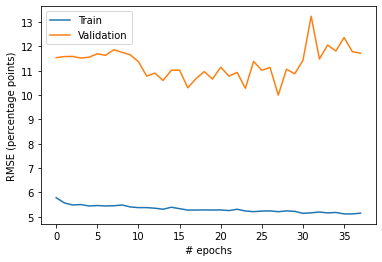

In [91]:
pl.plot(np.sqrt(history.history['last_time_step_mse']) * 100, label='Train')
pl.plot(np.sqrt(history.history['val_last_time_step_mse']) * 100, label='Validation')
#pl.yscale('log')
pl.legend()
pl.xlabel('# epochs')
pl.ylabel('RMSE (percentage points)')
pl.show()

Vemos que o modelo consegue se ajustar aos dados de treinamento e chega a alcançar uma erro típico de 5 p.p. na previsão da variação do preço das ações em cerca de 35 épocas. Entretanto, a performance praticamente não evolui na amostra de validação, na qual não passa de 10 p.p.. Isso indica que os dados de treinamento (passados) não são representativos dos dados de validação (futuros). Em outras palavras, estamos apenas ajustando ruídos.

### Validation set performance

In [79]:
# Baseline prediction: predict the same price
y_val_true = Y_val[:, -1, 0]
y_val_pred = np.zeros_like(y_val_true)
print(np.round(mean_squared_error(y_val_true, y_val_pred, squared=False), 4))
print(np.round(np.sqrt(np.mean(last_time_step_mse(Y_val, np.zeros_like(Y_val)))), 4))

0.1176
0.1176


In [80]:
# Validation prediction performance:
y_val_pred = model.predict(X_val)[:, -1, 0]
y_val_true = Y_val[:, -1, 0]
mean_squared_error(y_val_true, y_val_pred, squared=False)

0.09994735189989085

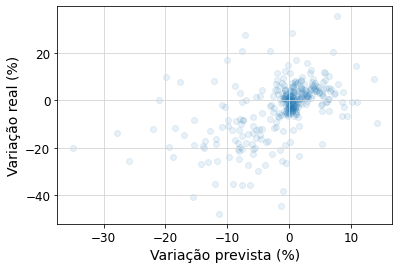

In [81]:
# Relação entre variação real e previsão:
predictions = build_predictions_df(val_df, X_val, y_val_true, y_val_pred, feature_cols)
plot_pred_vs_true_scatter(predictions)

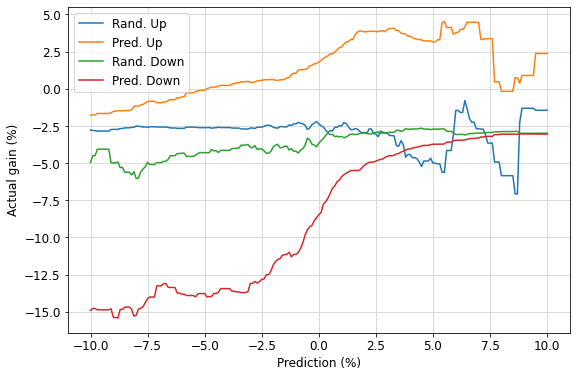

In [82]:
# Melhor corte para previsões:
pl.figure(figsize=(9, 6))
plot_gain_vs_trigger(predictions)
pl.show()

A performance do modelo na amostra de validação é ligeiramente melhor que o chute básico de estabilidade de preços. 
Entretanto, nós usamos a amostra de validação para decidir em qual época parar o modelo. Isso faz com que o modelo se ajuste aos ruídos da amostra de validação também.
Para tirar a teima, vamos verificar a performance do modelo na amostra teste, que nunca foi usada na elaboração do modelo.

### Test set performance

In [83]:
# Previsão: zero
y_test_true = Y_test[:, -1, 0]
y_test_pred = np.zeros_like(y_test_true)
print(np.round(mean_squared_error(y_test_true, y_test_pred, squared=False), 4))
print(np.round(np.sqrt(np.mean(last_time_step_mse(Y_test, np.zeros_like(Y_test)))), 4))

0.0424
0.0424


In [84]:
# Test prediction performance:
y_test_pred = model.predict(X_test)[:, -1, 0]
y_test_true = Y_test[:, -1, 0]
mean_squared_error(y_test_true, y_test_pred, squared=False)

0.04585159987058504

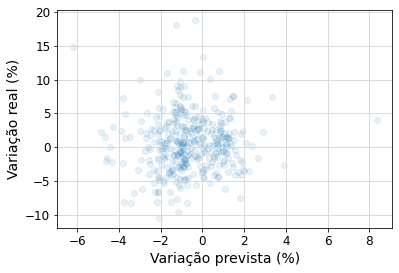

In [85]:
# Relação entre variação real e previsão:
test_predictions = build_predictions_df(test_df, X_test, y_test_true, y_test_pred, feature_cols)
plot_pred_vs_true_scatter(test_predictions)

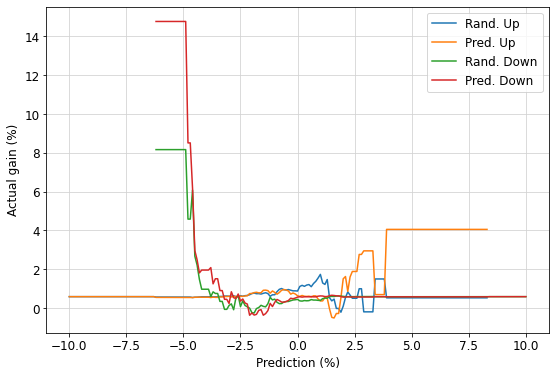

In [86]:
# Melhor corte para previsões:
pl.figure(figsize=(9, 6))
plot_gain_vs_trigger(test_predictions)
pl.show()

Vemos que o modelo não é capaz de prever a variação do preço das ações. Isso indica que ele se ajustou a ruídos, sem efetivamente capturar algum comportamento real dos dados. 

**Conclusão:** os preços futuros não são definidos ou influenciados pelos preços passados. Logo, uma análise grafista com os dados utilizados aqui não é capaz de prever preços das ações.

### Teste do modelo com uma ação

In [199]:
def predict_one_stock_price(model, input_df, feature_cols):

    # Get last recorded price: 
    last_input_price = input_df['preco_ultimo'].iloc[-1]
    
    # Predict price:
    y_var = model.predict(np.array([input_df[feature_cols].values]))[0, -1, 0]
    predicted_price = last_input_price * (1 + y_var)
    
    return predicted_price

In [122]:
def get_one_stock_subseries(df, papel, last_input_date, n_days_input, predict_window=None):
    
    # Select the specified stock:
    sel = get_stock(df, papel).reset_index(drop=True)
    
    # Build the subseries DataFrame: 
    last_input_idx = sel.loc[sel['data_pregao'] == last_input_date].index[0]
    input_df = sel.iloc[last_input_idx - n_days_input + 1: last_input_idx + 1]
    
    if type(predict_window) != type(None):
        target_true_price = sel.loc[last_input_idx + predict_window, 'preco_ultimo']
        target_date       = sel.loc[last_input_idx + predict_window, 'data_pregao']
        return input_df, target_date, target_true_price
    else:
        return input_df

In [123]:
papeis = val_df['cod_negociacao_papel'].unique()

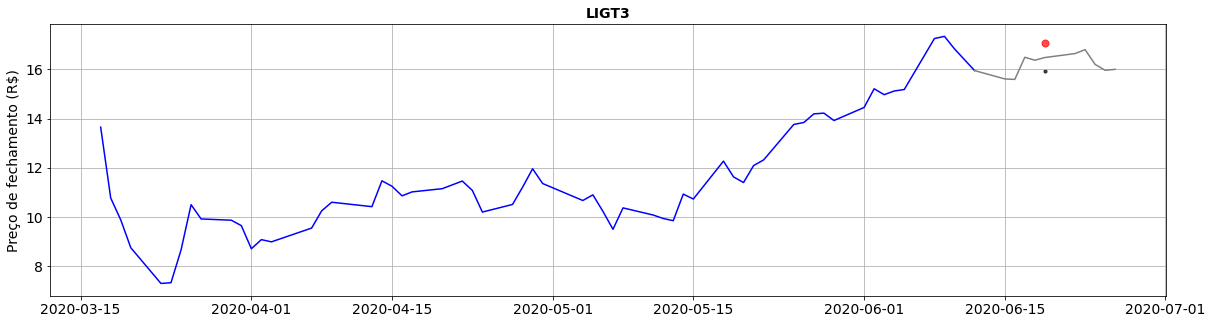

In [125]:
sel_pred = predictions.loc[predictions['pred'] > 0.05].sample()
#sel_pred

#papel = papeis[np.random.randint(0, len(papeis))]
#last_input_date = pd.to_datetime('2020-04-01') + pd.DateOffset(days=np.random.randint(-90, 90))
papel = sel_pred.iloc[0]['cod_negociacao_papel']
last_input_date = sel_pred.iloc[0]['data_pregao']

input_df, future_date, future_price = get_one_stock_subseries(val_df, papel, last_input_date, n_days_input, predict_window)
predicted_price = predict_one_stock_price(model, input_df, feature_cols)
last_known_price = input_df.loc[input_df['data_pregao'] == input_df['data_pregao'].max(), 'preco_ultimo'].iloc[0]
future_df = val_df.loc[(val_df['cod_negociacao_papel'] == papel) & (val_df['data_pregao'] >= last_input_date) & (val_df['data_pregao'] <= pd.to_datetime(last_input_date) + pd.DateOffset(days=14))]

pl.figure(figsize=(20,5))
pl.title(papel, fontsize=14, fontweight='bold')
pl.plot(input_df['data_pregao'], input_df['preco_ultimo'], color='b', label='Dados de input')
pl.plot(future_df['data_pregao'], future_df['preco_ultimo'], color='gray', label='Futuro')
pl.scatter([future_date], [predicted_price], c='r', alpha=0.7, s=50)
pl.scatter([future_date], [last_known_price], c='k', alpha=0.7, s=10)
pl.grid()
pl.tick_params(labelsize=14)
pl.ylabel('Preço de fechamento (R$)', fontsize=14)
pl.show()

## Exploração dos dados

Nesta seção nós estudamos os dados de input. Em ordem cronológica, ela foi criada antes da seção anterior, de criação do modelo.

### Preços intraday

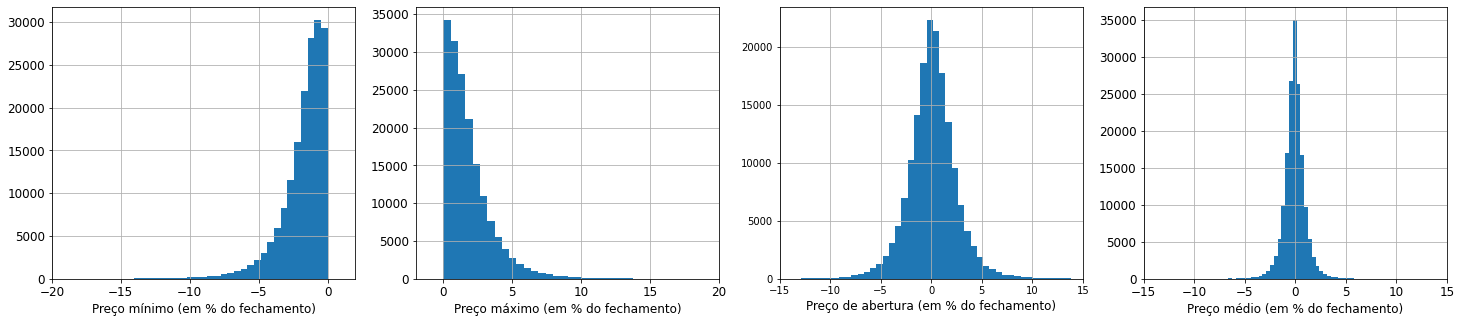

In [25]:
# Comparação de preços intra-day:
pl.figure(figsize=(25,5))
pl.subplot(1,4,1)
(frac_price_diff(easy_stocks, 'minimo') * 100).hist(bins=150)
pl.xlabel('Preço mínimo (em % do fechamento)', fontsize=12)
pl.xlim([-20, 2])
pl.tick_params(labelsize=12)
pl.subplot(1,4,2)
(frac_price_diff(easy_stocks, 'maximo') * 100).hist(bins=150)
pl.xlabel('Preço máximo (em % do fechamento)', fontsize=12)
pl.xlim([-2, 20])
pl.tick_params(labelsize=12)
pl.subplot(1,4,3)
(frac_price_diff(easy_stocks, 'abertura') * 100).hist(bins=150)
pl.xlabel('Preço de abertura (em % do fechamento)', fontsize=12)
pl.xlim([-15, 15])
pl.subplot(1,4,4)
(frac_price_diff(easy_stocks, 'preco_medio') * 100).hist(bins=150)
pl.xlabel('Preço médio (em % do fechamento)', fontsize=12)
pl.xlim([-15, 15])
pl.tick_params(labelsize=12)

### Preços por dia da semana

Parece que o preço de fechamento na terça tende a ser 0,25% maior que o preço de fechamento da segunda. Logo, uma estratégia pode ser comprar na terça quando o preço ficar abaixo do valor de fechamento da segunda.

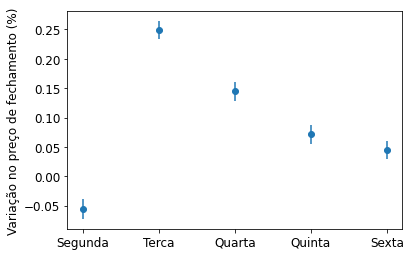

In [26]:
# Média da variação de preços por dia da semana:
price_col = 'frac_preco_ultimo'
avg_change_by_weekday = easy_stocks.groupby(easy_stocks['data_pregao'].dt.weekday)[price_col].mean() * 100
dev_avg_change_by_weekday = easy_stocks.groupby(easy_stocks['data_pregao'].dt.weekday)[price_col].std() * 100 / np.sqrt(easy_stocks.groupby(easy_stocks['data_pregao'].dt.weekday).size())
weekday_name = {0: 'Segunda', 1: 'Terca', 2: 'Quarta', 3: 'Quinta', 4: 'Sexta'}
pl.errorbar(avg_change_by_weekday.index.map(weekday_name), avg_change_by_weekday, yerr=dev_avg_change_by_weekday, linestyle='none', marker='o')
pl.tick_params(labelsize=12)
pl.ylabel('Variação no preço de fechamento (%)', fontsize=12)
pl.show()

### Análise das variáveis log

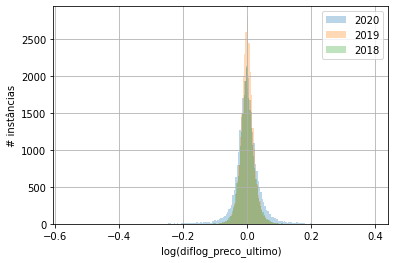

In [57]:
col = 'diflog_preco_ultimo'
easy_stocks.loc[easy_stocks['data_pregao'].dt.year == 2020][col].hist(bins=200, alpha=0.3, label=2020)
easy_stocks.loc[easy_stocks['data_pregao'].dt.year == 2019][col].hist(bins=200, alpha=0.3, label=2019)
easy_stocks.loc[easy_stocks['data_pregao'].dt.year == 2018][col].hist(bins=200, alpha=0.3, label=2018)
pl.xlabel('log({})'.format(col))
pl.ylabel('# instâncias')
pl.legend()
pl.show()

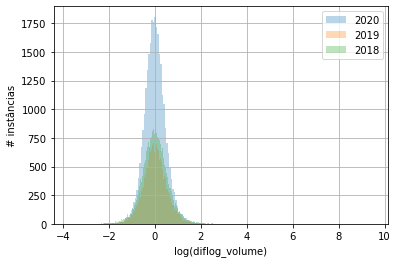

In [53]:
col = 'diflog_volume'
easy_stocks.loc[easy_stocks['data_pregao'].dt.year == 2020][col].hist(bins=200, alpha=0.3, label=2020)
easy_stocks.loc[easy_stocks['data_pregao'].dt.year == 2019][col].hist(bins=200, alpha=0.3, label=2019)
easy_stocks.loc[easy_stocks['data_pregao'].dt.year == 2018][col].hist(bins=200, alpha=0.3, label=2018)
pl.xlabel('log({})'.format(col))
pl.ylabel('# instâncias')
pl.legend()
pl.show()

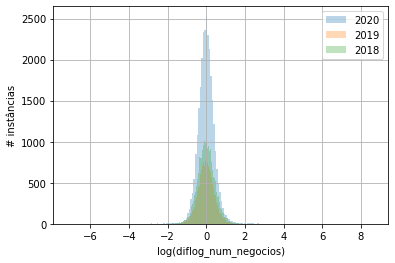

In [54]:
col = 'diflog_num_negocios'
easy_stocks.loc[easy_stocks['data_pregao'].dt.year == 2020][col].hist(bins=200, alpha=0.3, label=2020)
easy_stocks.loc[easy_stocks['data_pregao'].dt.year == 2019][col].hist(bins=200, alpha=0.3, label=2019)
easy_stocks.loc[easy_stocks['data_pregao'].dt.year == 2018][col].hist(bins=200, alpha=0.3, label=2018)
pl.xlabel('log({})'.format(col))
pl.ylabel('# instâncias')
pl.legend()
pl.show()

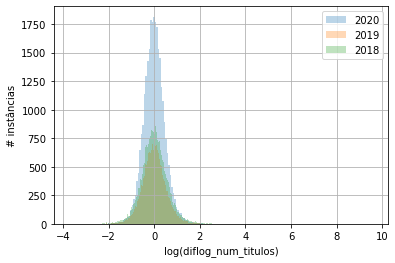

In [55]:
col = 'diflog_num_titulos'
easy_stocks.loc[easy_stocks['data_pregao'].dt.year == 2020][col].hist(bins=200, alpha=0.3, label=2020)
easy_stocks.loc[easy_stocks['data_pregao'].dt.year == 2019][col].hist(bins=200, alpha=0.3, label=2019)
easy_stocks.loc[easy_stocks['data_pregao'].dt.year == 2018][col].hist(bins=200, alpha=0.3, label=2018)
pl.xlabel('log({})'.format(col))
pl.ylabel('# instâncias')
pl.legend()
pl.show()

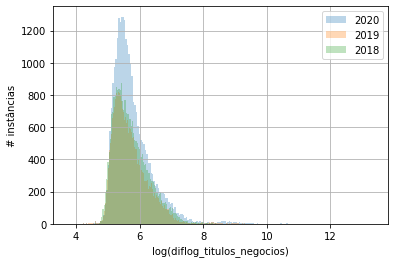

In [56]:
col = 'diflog_titulos_negocios'
easy_stocks.loc[easy_stocks['data_pregao'].dt.year == 2020][col].hist(bins=200, alpha=0.3, label=2020)
easy_stocks.loc[easy_stocks['data_pregao'].dt.year == 2019][col].hist(bins=200, alpha=0.3, label=2019)
easy_stocks.loc[easy_stocks['data_pregao'].dt.year == 2018][col].hist(bins=200, alpha=0.3, label=2018)
pl.xlabel('log({})'.format(col))
pl.ylabel('# instâncias')
pl.legend()
pl.show()

### Evolução temporal da distribuição do volume e outros indicadores similares

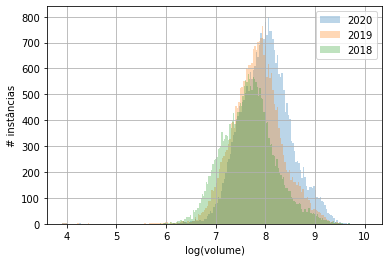

In [45]:
col = 'volume'
np.log10(easy_stocks.loc[easy_stocks['data_pregao'].dt.year == 2020][col]).hist(bins=200, alpha=0.3, label=2020)
np.log10(easy_stocks.loc[easy_stocks['data_pregao'].dt.year == 2019][col]).hist(bins=200, alpha=0.3, label=2019)
np.log10(easy_stocks.loc[easy_stocks['data_pregao'].dt.year == 2018][col]).hist(bins=200, alpha=0.3, label=2018)
pl.xlabel('log({})'.format(col))
pl.ylabel('# instâncias')
pl.legend()
pl.show()

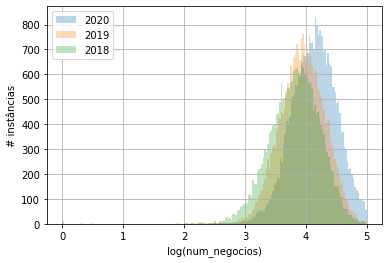

In [29]:
col = 'num_negocios'
np.log10(easy_stocks.loc[easy_stocks['data_pregao'].dt.year == 2020][col]).hist(bins=200, alpha=0.3, label=2020)
np.log10(easy_stocks.loc[easy_stocks['data_pregao'].dt.year == 2019][col]).hist(bins=200, alpha=0.3, label=2019)
np.log10(easy_stocks.loc[easy_stocks['data_pregao'].dt.year == 2018][col]).hist(bins=200, alpha=0.3, label=2018)
pl.xlabel('log({})'.format(col))
pl.ylabel('# instâncias')
pl.legend()
pl.show()

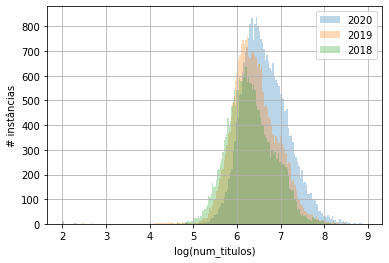

In [30]:
col = 'num_titulos'
np.log10(easy_stocks.loc[easy_stocks['data_pregao'].dt.year == 2020][col]).hist(bins=200, alpha=0.3, label=2020)
np.log10(easy_stocks.loc[easy_stocks['data_pregao'].dt.year == 2019][col]).hist(bins=200, alpha=0.3, label=2019)
np.log10(easy_stocks.loc[easy_stocks['data_pregao'].dt.year == 2018][col]).hist(bins=200, alpha=0.3, label=2018)
pl.xlabel('log({})'.format(col))
pl.ylabel('# instâncias')
pl.legend()
pl.show()

### Correlação com lag entre preços de uma mesma ação

In [31]:
def lag_corr(series, lag, other=None):
    
    if type(other) == type(None):
        return series.corr(series.shift(lag))
    else:
        return series.corr(other.shift(lag))

In [32]:
# Seleciona ações com série histórica longa:
n_days_per_stock = easy_stocks.value_counts('cod_negociacao_papel')
long_stocks = n_days_per_stock.loc[n_days_per_stock > 1200].index

In [33]:
# Calcula auto-correlações com lag para todas:
lags = np.arange(0, 61)
corrs = []
for stock in long_stocks:
    sel = easy_stocks.loc[easy_stocks['cod_negociacao_papel'] == stock].copy().reset_index()
    corr_vs_lag = [lag_corr(sel['frac_preco_ultimo'].iloc[1:], lag) for lag in lags]
    corrs.append(corr_vs_lag)

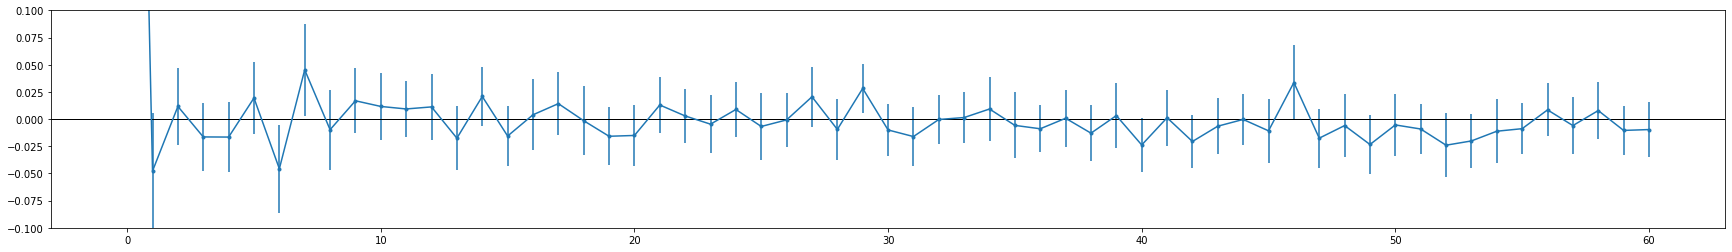

In [34]:
# Plota a média das auto-correlações com lag:
mean_corr = np.array(corrs).mean(axis=0)
dev_corr  = np.array(corrs).std(axis=0)
pl.figure(figsize=(30,4))
pl.errorbar(lags, mean_corr, yerr=dev_corr, marker='.')
pl.axhline(0, linewidth=1, color='k')
pl.ylim([-0.1, 0.1])
pl.show()

Não existe nenhuma correlação entre a variação do preço das ações em dias diferentes.

### Análise de variabilidade dos preços

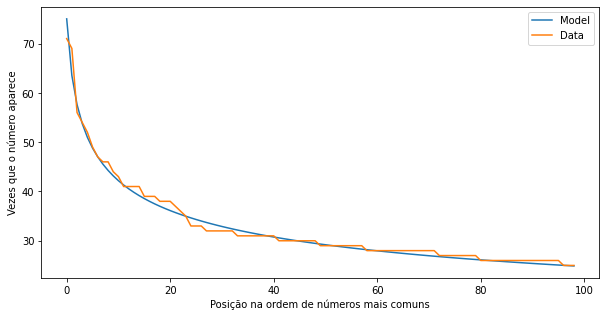

In [35]:
x = np.arange(1,100)
pl.figure(figsize=(10,5))
pl.plot(75 / x**0.24, label='Model')
frac_diff_freq = easy_stocks['frac_preco_ultimo'].value_counts().sort_values(ascending=False).iloc[1:100]
pl.plot(frac_diff_freq.values, label='Data')
pl.legend()
pl.xlabel('Posição na ordem de números mais comuns')
pl.ylabel('Vezes que o número aparece')
pl.show()

In [36]:
value_counts = easy_stocks['frac_preco_ultimo'].sort_values().reset_index(drop=True).reset_index()
value_counts.rename({'index':'percentile'}, axis=1, inplace=True)
value_counts['percentile'] = value_counts['percentile'] + 1
value_counts['percentile'] = value_counts['percentile'] / value_counts['percentile'].iloc[-1]
value_counts = value_counts.drop_duplicates(subset='frac_preco_ultimo', keep='last')

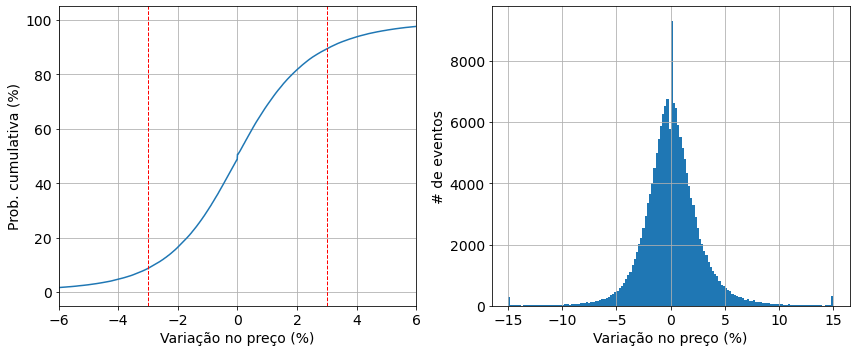

In [37]:
extreme = 0.03

pl.figure(figsize=(12,5))

pl.subplot(1,2,1)
pl.plot(value_counts['frac_preco_ultimo'] * 100, value_counts['percentile'] * 100)
pl.xlim([-6, 6])
pl.xlabel('Variação no preço (%)', fontsize=14)
pl.ylabel('Prob. cumulativa (%)', fontsize=14)
pl.tick_params(labelsize=14)

pl.axvline(extreme * 100, color='r', linewidth=1, linestyle='--')
pl.axvline(-extreme * 100, color='r', linewidth=1, linestyle='--')
pl.grid()

pl.subplot(1,2,2)
(easy_stocks['frac_preco_ultimo'].clip(-0.15, 0.15) * 100).hist(bins=150)
pl.xlabel('Variação no preço (%)', fontsize=14)
pl.ylabel('# de eventos', fontsize=14)
pl.tick_params(labelsize=14)

pl.tight_layout()
pl.show()

O gráfico abaixo mostra que a variação em R$ do preço é mais dependente do valor da ação (que depende da inflação e de agrupamentos/desdobramentos) do que a variação fracional. Logo, pode ser mais estável para o modelo o uso da variação fracional de preço.

In [38]:
easy_stocks['cod_negociacao_papel'].unique()

165: ABEV3 | AERI3 | AESB3 | ALLL3 | ALSO3 | ARZZ3 | ASAI3 | AZUL4 | B3SA3 | BBAS3 | BBDC3 | BBDC4 | BBSE3 | BBTG11 | BEEF3 | BIDI11 | BIDI4 | BKBR3 | BLAU3 | BMGB11 | BMOB3 | BOVA11 | BPAC11 | BRAP4 | BRBI11 | BRDT3 | BRFS3 | BRKM5 | BRML3 | BRSR6 | BTOW3 | BVMF3 | CASH3 | CCRO3 | CEAB3 | CESP6 | CIEL3 | CMIG4 | CMIN3 | CNTO3 | COGN3 | CPFE3 | CPLE11 | CPLE6 | CRFB3 | CRUZ3 | CSAN3 | CSMG3 | CSNA3 | CTIP3 | CVCB3 | CXSE3 | CYRE3 | DEXP3 | DTEX3 | ECOR3 | EGIE3 | ELET3 | ELET6 | ELPL4 | EMBR3 | ENAT3 | ENBR3 | ENGI11 | ENJU3 | EQTL3 | ESPA3 | ESTC3 | EZTC3 | FIBR3 | FLRY3 | GETI4 | GFSA3 | GGBR4 | GGPS3 | GMAT3 | GNDI3 | GOAU4 | GOLL4 | HAPV3 | HASH11 | HBSA3 | HGTX3 | HYPE3 | IGTA3 | INTB3 | IRBR1 | IRBR3 | IRBR9 | ITSA4 | ITUB4 | JBSS3 | KLBN11 | KROT3 | LAME4 | LIGT3 | LINX3 | LJQQ3 | LREN3 | LWSA3 | MDIA3 | MGLU3 | MOSI3 | MOVI3 | MRFG3 | MRVE3 | MULT3 | MYPK3 | NATU3 | NEOE3 | NGRD3 | NTCO3 | ODPV3 | OIBR3 | PCAR3 | PCAR4 | PETR3 | PETR4 | PETZ3 | POMO4 | PSSA3 | QUAL3 | RADL3 | R

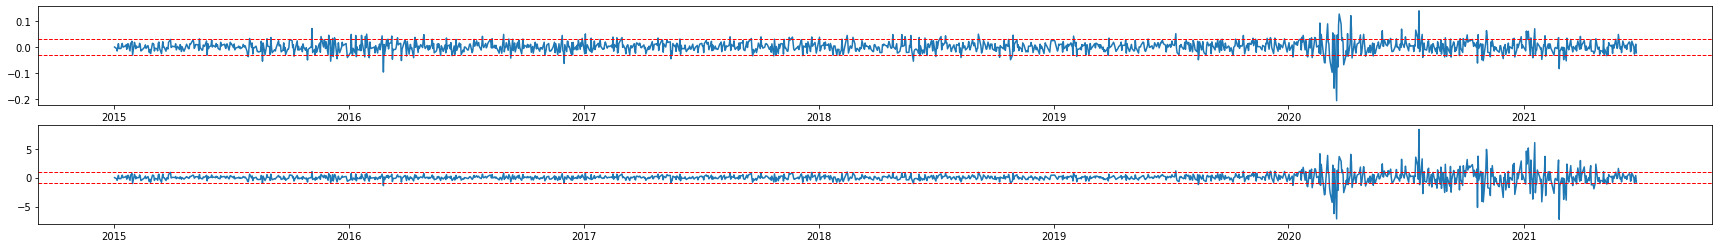

In [39]:
sel = easy_stocks.loc[easy_stocks['cod_negociacao_papel'] == 'WEGE3'].copy().reset_index()

# Variação do preço e variação fracional do preço ao longo do tempo:
pl.figure(figsize=(30,4))

pl.subplot(2,1,1)
pl.plot(sel['data_pregao'], sel['frac_preco_ultimo'])
pl.axhline(-extreme, color='r', linewidth=1, linestyle='--')
pl.axhline(extreme, color='r', linewidth=1, linestyle='--')

pl.subplot(2,1,2)
pl.plot(sel['data_pregao'], sel['delta_preco_ultimo'])
pl.axhline(sel['delta_preco_ultimo'].std(), color='r', linewidth=1, linestyle='--')
pl.axhline(-sel['delta_preco_ultimo'].std(), color='r', linewidth=1, linestyle='--')

pl.show()

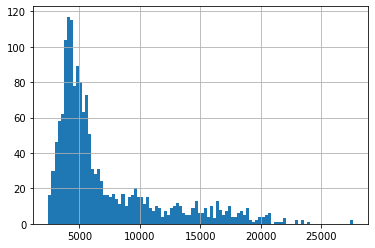

In [40]:
avg_deal_value = (sel['volume'] / sel['num_negocios']).clip(upper=100000)
avg_deal_value.hist(bins=100)
pl.show()

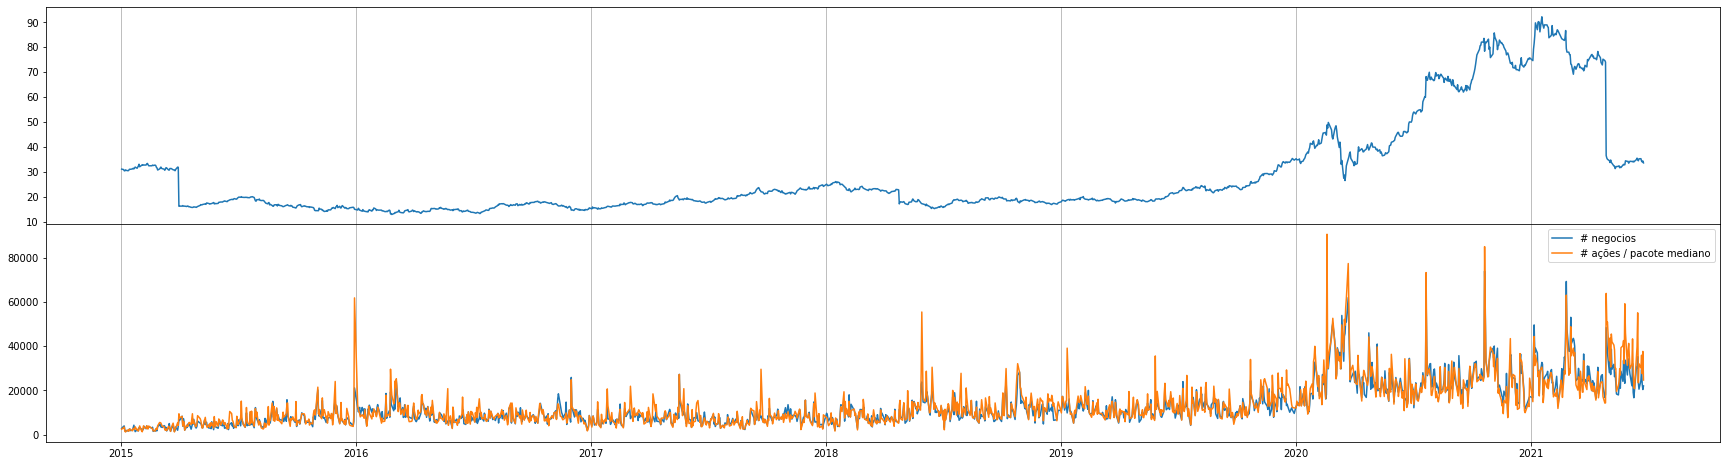

In [41]:
pl.figure(figsize=(30,8))
pl.subplot(2,1,1)
pl.plot(sel['data_pregao'], sel['preco_ultimo'])
pl.grid(axis='x')

avg_deal_size = (sel['num_titulos'] / sel['num_negocios'])#.clip(lower=0, upper=10000)
pl.subplot(2,1,2)
pl.plot(sel['data_pregao'], sel['num_negocios'], label='# negocios')
pl.plot(sel['data_pregao'], sel['num_titulos'] / avg_deal_size.median(), label='# ações / pacote mediano')
pl.grid(axis='x')
pl.legend()
pl.subplots_adjust(hspace=0)
pl.show()

O gráfico abaixo mostra que o **volume** é dado pelo **número de ações** (títulos) trocados no dia multiplicado pelo **preço de fechamento**.

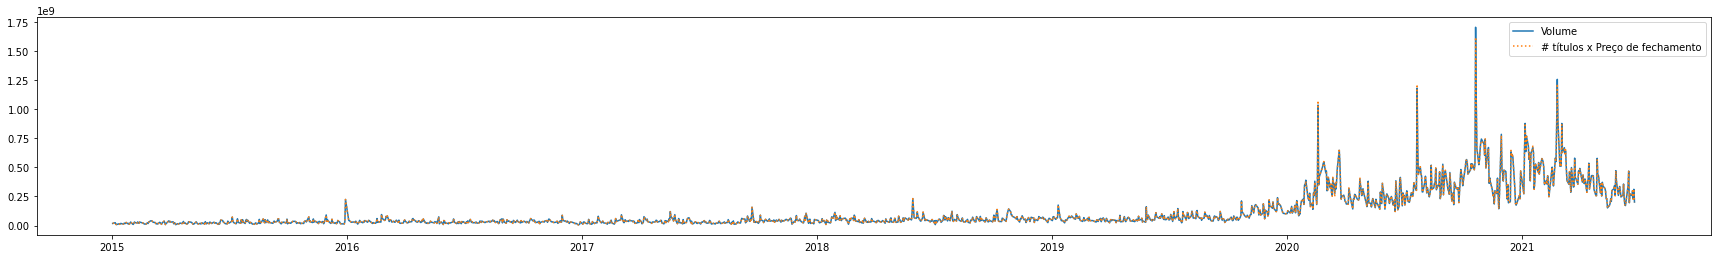

In [42]:
# Relação entre volume, núm de títulos e preço de fechamento:
pl.figure(figsize=(30,4))
pl.plot(sel['data_pregao'], sel['volume'], label='Volume')
pl.plot(sel['data_pregao'], sel['num_titulos'] * sel['preco_ultimo'], linestyle='dotted', label='# títulos x Preço de fechamento')
pl.legend()
pl.show()

### Análise da evolução de preços

In [43]:
def plot_col(df, col, log=False):
    
    pl.plot(df['data_pregao'], df[col], label=col)
    pl.grid()

    critic_events = df.loc[df['quebra_preco'] == 1]
    critic_dates  = critic_events['data_pregao']
    critic_text   = critic_events['eventos']
    min_price     = df[col].min()
    for dt, e in zip(critic_dates, critic_text):
        pl.axvline(dt, color='k', linewidth=1)
        pl.text(dt, min_price, ' ' + e)

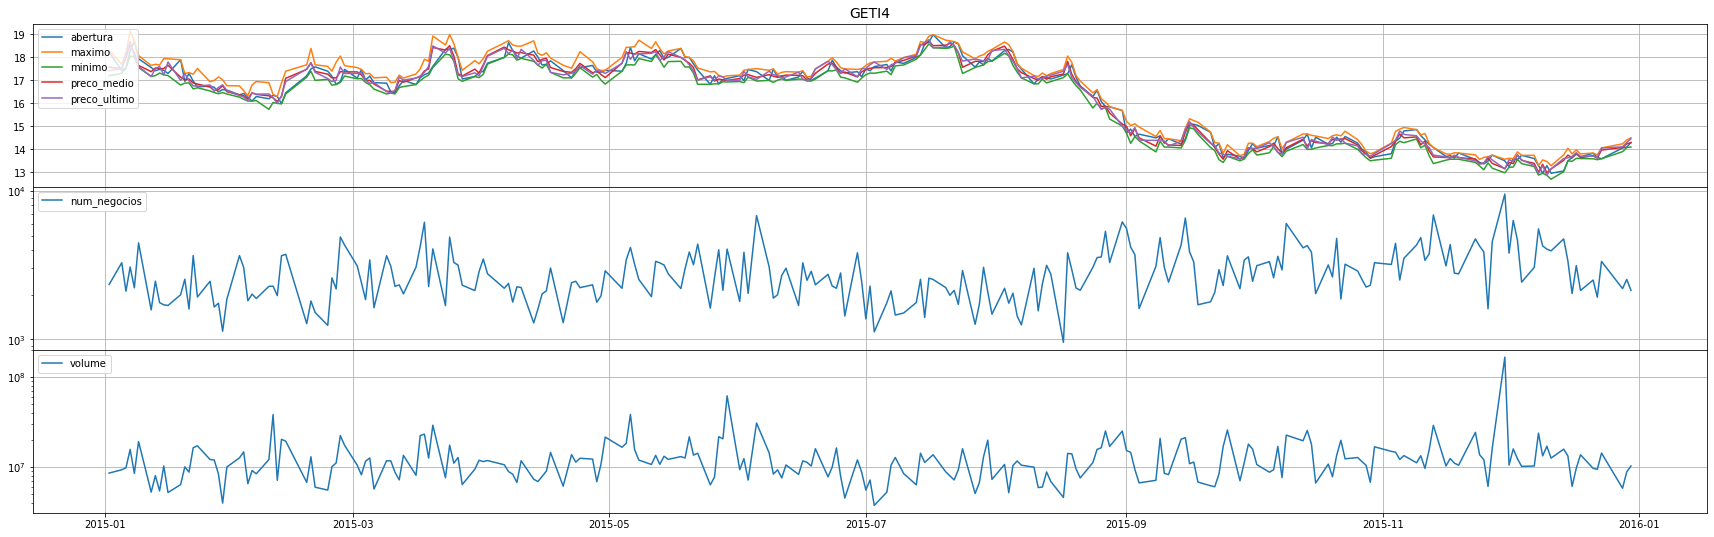

In [44]:
i = np.random.randint(0, len(easy_stocks_list))
test_stock = easy_stocks.loc[easy_stocks['cod_negociacao_papel'] == easy_stocks_list[i]]

pl.figure(figsize=(30, 3 * 3))

pl.subplot(3, 1, 1)
for col in ['abertura', 'maximo', 'minimo', 'preco_medio', 'preco_ultimo']:
    plot_col(test_stock, col)
pl.legend(loc='upper left')
pl.title(test_stock['cod_negociacao_papel'].unique()[0], fontsize=14)

for i, col in enumerate(['num_negocios', 'volume']):
    pl.subplot(3,1, i + 2)
    plot_col(test_stock, col)
    pl.legend(loc='upper left')
    pl.yscale('log')
    
pl.subplots_adjust(hspace=0)
pl.show()

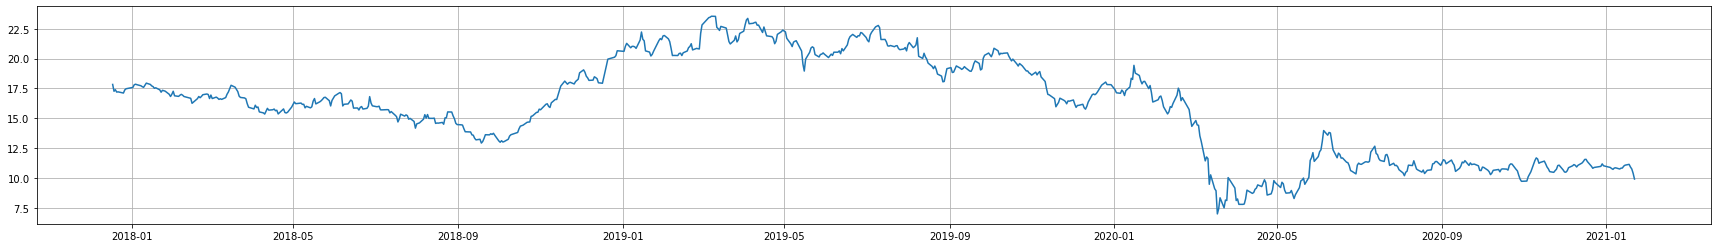

In [70]:
sel = df.loc[(df['cod_negociacao_papel'].isin(['BKBR3']))]

pl.figure(figsize=(30,4))

pl.plot(sel['data_pregao'], sel['preco_medio'])
#pl.plot(sel['data_pregao'], sel['volume'])
pl.grid()

critic_events = sel.loc[sel['quebra_preco'] == 1]
critic_dates  = critic_events['data_pregao']
critic_text   = critic_events['eventos']
min_price     = sel['preco_medio'].min()
for dt, e in zip(critic_dates, critic_text):
    pl.axvline(dt, color='k', linewidth=1)
    pl.text(dt, min_price, ' ' + e)
pl.show()

In [69]:
sel_stock_changes(df, 'BKBR3')

,data_pregao,especificacao_papel,preco_medio,num_distrib,num_negocios
247,2018-12-19,ON NM,18.88,100,1467
248,2018-12-20,ON EJ NM,19.43,101,7643
296,2019-03-07,ON NM,23.46,101,5880
297,2019-03-08,ON EJ NM,23.54,102,5654
541,2020-03-02,ON NM,14.81,102,6664
542,2020-03-03,ON EJ NM,14.44,103,7856


### Distribuição de volume e \# negócios para empresas selecionadas

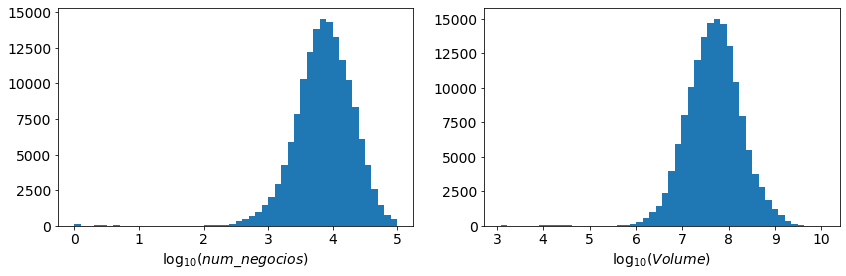

In [38]:
pl.figure(figsize=(14, 4))

pl.subplot(1,2,1)
pl.hist(np.log10(df.loc[df['cod_negociacao_papel'].isin(easy_stocks_list)]['num_negocios']), bins=50)
pl.xlabel('$\log_{10}(num\_negocios)$', fontsize=14)
pl.tick_params(labelsize=14)

pl.subplot(1,2,2)
pl.hist(np.log10(df.loc[df['cod_negociacao_papel'].isin(easy_stocks_list)]['volume']), bins=50)
pl.xlabel('$\log_{10}(Volume)$', fontsize=14)
pl.tick_params(labelsize=14)

pl.show()

In [30]:
all_stocks = sorted(df['cod_negociacao_papel'].unique())

### Outras coisas

In [13]:
# Load especificações de papéis table:
especificacoes = pd.read_csv('../dados/aux/siglas_especificacoes_papel.csv')
assert len(especificacoes['sigla'].drop_duplicates()) == len(especificacoes['sigla'])

In [14]:
especificacoes

,sigla,especificacao_papel
0,BDR,BDR
1,BNS,BÔNUS DE SUBSCRIÇÃO EM ACÕES MISCELÂNEA
2,BNS B/A,BÔNUS DE SUBSCRIÇÃO EM ACÕES PREFERÊNCIA
3,BNS ORD,BÔNUS DE SUBSCRIÇÃO EM ACÕES ORDINÁRIAS
4,BNS P/A,BÔNUS DE SUBSCRIÇÃO EM ACÕES PREFERÊNCIA
...,...,...
96,PND REC,RECIBO DE SUBSCRIÇÃO EM ACÕES PREFERENCIAIS
97,PNE,ACÕES PREFERÊNCIAIS NOMINATIVAS CLASSE E
98,PNE ED,Ações Preferenciais Classe E Ex-Dividendo
99,PNE P,ACÕES PREFERÊNCIAIS NOMINATIVAS CLASSE E
